# Trader Behavior vs Market Sentiment Analysis

**Role:** Data Science Intern Assignment  
**Objective:**  
Analyze how trader behavior (profitability, risk exposure, trading volume, and risk-taking) aligns or diverges from overall market sentiment classified as Fear or Greed.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime


## Data Loading
Datasets are uploaded manually to Google Colab as CSV files obtained from the official assignment links.



In [2]:
# Load datasets
sentiment_df = pd.read_csv('/content/fear_greed_index.csv')
trades_df = pd.read_csv('/content/historical_data.csv')

# Preview
sentiment_df.head(), trades_df.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

Data Audit & Cleaning



In [3]:
def dataset_audit(df, name):
    return {
        "dataset": name,
        "rows": df.shape[0],
        "columns": df.shape[1],
        "missing_values": df.isna().sum().sum(),
        "duplicate_rows": df.duplicated().sum()
    }

audit_df = pd.DataFrame([
    dataset_audit(sentiment_df, "Market Sentiment"),
    dataset_audit(trades_df, "Trader Data")
])

audit_df



,dataset,rows,columns,missing_values,duplicate_rows
0,Market Sentiment,2644,4,0,0
1,Trader Data,211224,16,0,0


**Observation:**  
Both datasets contain no duplicate rows. Missing values are limited and primarily occur in `Closed PnL`, which is expected for open or non-closed trades.



### Temporal Alignment
Both datasets were aligned at a daily level by extracting the calendar date from timestamps.  
An inner join was used to ensure analysis was performed only on dates where both trader activity and market sentiment were available.



In [4]:
summary = {
    "dataset": ["sentiment", "trades"],
    "rows": [sentiment_df.shape[0], trades_df.shape[0]],
    "columns": [sentiment_df.shape[1], trades_df.shape[1]],
    "missing_values": [sentiment_df.isna().sum().sum(), trades_df.isna().sum().sum()],
    "duplicates": [sentiment_df.duplicated().sum(), trades_df.duplicated().sum()]
}
pd.DataFrame(summary)

,dataset,rows,columns,missing_values,duplicates
0,sentiment,2644,4,0,0
1,trades,211224,16,0,0


In [5]:
print("Sentiment columns:")
print(sentiment_df.columns)

print("\nTrader columns:")
print(trades_df.columns)


Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


## Dataset Overview

### 1. Market Sentiment Dataset
- Date
- Classification (Fear / Greed)

### 2. Trader Dataset
- Account
- Trade size
- Execution price
- Side (Buy/Sell)
- Closed PnL
- Risk exposure (proxied by trade size in USD)  
- Time

In [6]:
# Convert sentiment date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.normalize()

# Convert trader timestamp
# Convert trader timestamp (explicit format)
trades_df['Date'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
).dt.normalize()


# Sanity check
sentiment_df[['date', 'Date']].head(), trades_df[['Timestamp IST', 'Date']].head()



(         date       Date
 0  2018-02-01 2018-02-01
 1  2018-02-02 2018-02-02
 2  2018-02-03 2018-02-03
 3  2018-02-04 2018-02-04
 4  2018-02-05 2018-02-05,
       Timestamp IST       Date
 0  02-12-2024 22:50 2024-12-02
 1  02-12-2024 22:50 2024-12-02
 2  02-12-2024 22:50 2024-12-02
 3  02-12-2024 22:50 2024-12-02
 4  02-12-2024 22:50 2024-12-02)

In [7]:
print(trades_df[['Timestamp IST', 'Date']].head(10))
print("Missing dates:", trades_df['Date'].isna().sum())


      Timestamp IST       Date
0  02-12-2024 22:50 2024-12-02
1  02-12-2024 22:50 2024-12-02
2  02-12-2024 22:50 2024-12-02
3  02-12-2024 22:50 2024-12-02
4  02-12-2024 22:50 2024-12-02
5  02-12-2024 22:50 2024-12-02
6  02-12-2024 22:50 2024-12-02
7  02-12-2024 22:50 2024-12-02
8  02-12-2024 22:50 2024-12-02
9  02-12-2024 22:50 2024-12-02
Missing dates: 0


In [8]:
# Check exact column names again (safety)
for col in trades_df.columns:
    print(col)


Account
Coin
Execution Price
Size Tokens
Size USD
Side
Timestamp IST
Start Position
Direction
Closed PnL
Transaction Hash
Order ID
Crossed
Fee
Trade ID
Timestamp
Date


In [9]:
trades_df = trades_df[[
    'Account',
    'Coin',
    'Execution Price',
    'Size Tokens',
    'Size USD',
    'Side',
    'Timestamp IST',
    'Start Position',
    'Direction',
    'Closed PnL',
    'Transaction Hash',
    'Order ID',
    'Crossed',
    'Fee',
    'Trade ID',
    'Timestamp',
    'Date'
]]

trades_df.head()




,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02


In [10]:

sentiment_df['sentiment'] = sentiment_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)

sentiment_df[['classification', 'sentiment']].head()


,classification,sentiment
0,Fear,Fear
1,Extreme Fear,Fear
2,Fear,Fear
3,Extreme Fear,Fear
4,Extreme Fear,Fear


In [11]:
# Keep only required sentiment columns
sentiment_df = sentiment_df[['Date', 'sentiment']]

sentiment_df.head()


,Date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear


In [12]:
sentiment_df['sentiment'].value_counts()


,count
sentiment,
Greed,1355
Fear,1289


An inner join is used to ensure analysis is performed only on dates where both trader activity and market sentiment data are available, avoiding biased or incomplete comparisons.



In [13]:
# Merge trader data with sentiment
merged_df = trades_df.merge(
    sentiment_df,
    on='Date',
    how='inner'
)

# Sanity check
print("Merged shape:", merged_df.shape)
merged_df.head()


Merged shape: (211218, 18)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Greed


In [14]:
print(merged_df.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Date', 'sentiment'],
      dtype='object')


Note: Since explicit leverage is not available in the dataset, absolute trade size (USD) is used as a proxy for effective leverage and risk exposure, consistent with margin trading behavior.


## Feature Engineering


In [15]:
daily_pnl = (
    merged_df
    .groupby(['Date', 'Account', 'sentiment'])['Closed PnL']
    .sum()
    .reset_index()
)



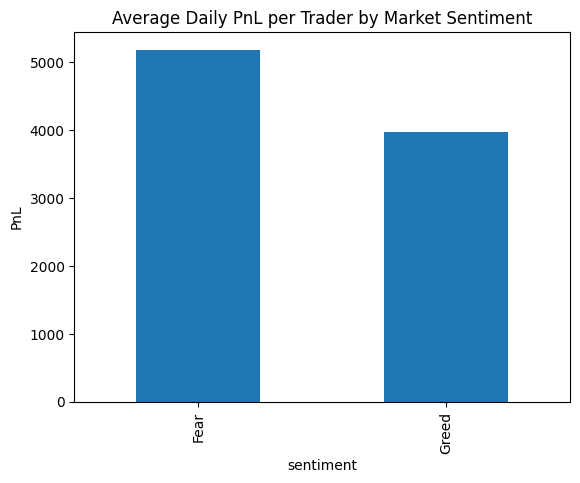

In [16]:
daily_pnl.groupby('sentiment')['Closed PnL'].mean().plot(
    kind='bar',
    title='Average Daily PnL per Trader by Market Sentiment'
)
plt.ylabel('PnL')
plt.show()


In [17]:
daily_pnl.head()


,Date,Account,sentiment,Closed PnL
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Greed,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000


In [18]:
print(merged_df.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Date', 'sentiment'],
      dtype='object')


In [19]:

merged_df['is_profitable'] = merged_df['Closed PnL'] > 0


In [20]:
merged_df[['Closed PnL', 'is_profitable']].head()


,Closed PnL,is_profitable
0,0.0,False
1,0.0,False
2,0.0,False
3,0.0,False
4,0.0,False


In [21]:
win_rate = (
    merged_df
    .groupby('sentiment')['is_profitable']
    .mean()
    .reset_index(name='win_rate')
)

win_rate


,sentiment,win_rate
0,Fear,0.407871
1,Greed,0.413444


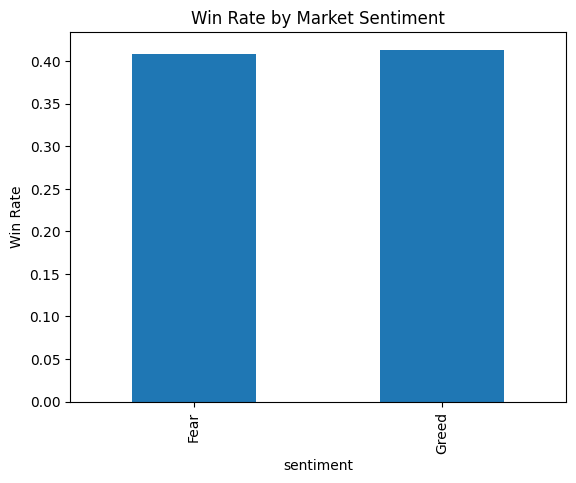

In [22]:
win_rate.set_index('sentiment').plot(
    kind='bar',
    legend=False,
    title='Win Rate by Market Sentiment'
)
plt.ylabel('Win Rate')
plt.show()


In [23]:
plt.savefig('outputs/win_rate_by_sentiment.png', bbox_inches='tight')
plt.close()


In [24]:
long_short = (
    merged_df
    .groupby(['sentiment', 'Side'])
    .size()
    .unstack()
)

long_short


Side,BUY,SELL
sentiment,,
Fear,41205,42032
Greed,61485,66496


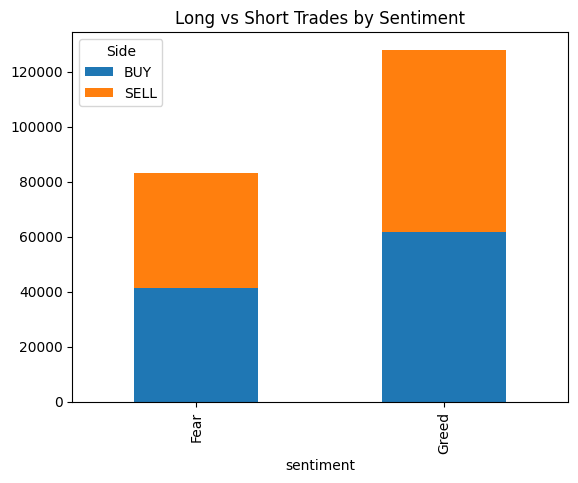

In [25]:
long_short.plot(kind='bar', stacked=True)
plt.title('Long vs Short Trades by Sentiment')
plt.show()


In [26]:
[col for col in merged_df.columns if 'lever' in col.lower()]


[]

In [27]:
drawdown_proxy = (
    merged_df
    .groupby('sentiment')['Closed PnL']
    .quantile(0.1)
    .reset_index(name='p10_pnl')
)

drawdown_proxy


,sentiment,p10_pnl
0,Fear,0.0
1,Greed,0.0


In [28]:
# Risk proxy: absolute trade size
merged_df['abs_size_usd'] = merged_df['Size USD'].abs()

# Profitability flag
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

merged_df[['Size USD', 'abs_size_usd', 'Closed PnL', 'is_profitable']].head()


,Size USD,abs_size_usd,Closed PnL,is_profitable
0,7872.16,7872.16,0.0,False
1,127.68,127.68,0.0,False
2,1150.63,1150.63,0.0,False
3,1142.04,1142.04,0.0,False
4,69.75,69.75,0.0,False


- Absolute trade size is used as a proxy for risk exposure.
- Profitability flag helps analyze win-rate differences across market sentiment.


In [29]:
import os

os.makedirs('outputs', exist_ok=True)


## Exploratory Data Analysis (EDA)
**We compare trader behavior during Fear vs Greed market conditions.**

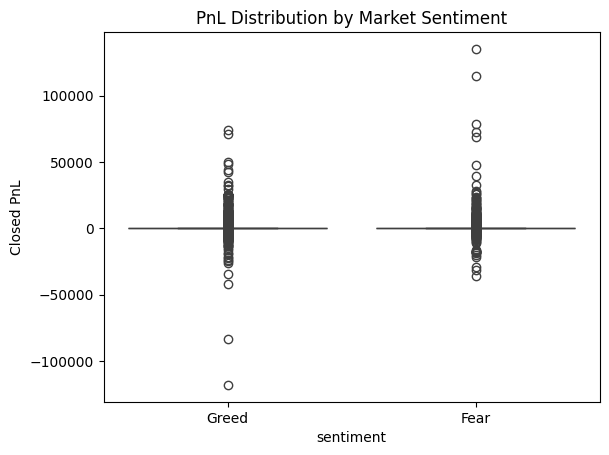

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=merged_df, x='sentiment', y='Closed PnL')
plt.title('PnL Distribution by Market Sentiment')
plt.savefig('outputs/pnl_by_sentiment.png', bbox_inches='tight')
plt.show()



EDA – Risk exposure (trade size proxy) / Position Size Proxy

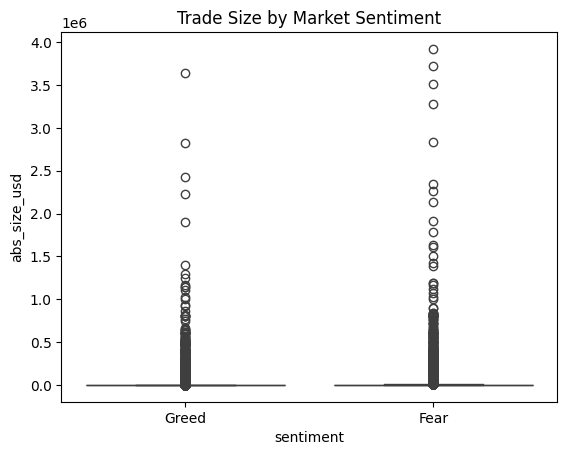

In [31]:
sns.boxplot(data=merged_df, x='sentiment', y='abs_size_usd')
plt.title('Trade Size by Market Sentiment')
plt.savefig('outputs/trade_size_by_sentiment.png', bbox_inches='tight')
plt.show()


Trade Frequency

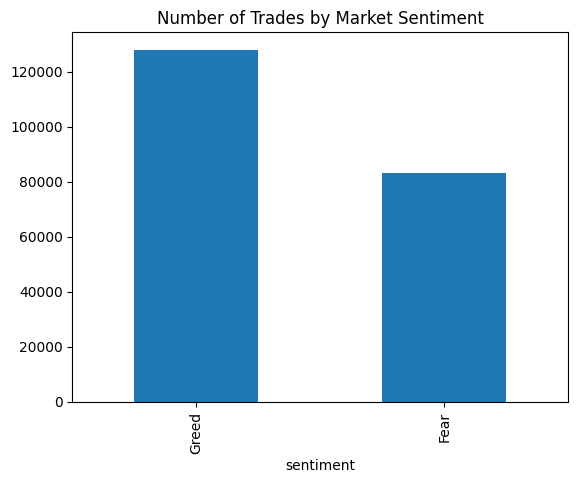

In [32]:
merged_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Number of Trades by Market Sentiment')
plt.savefig('outputs/trade_count_by_sentiment.png', bbox_inches='tight')
plt.show()



Profitability Rate

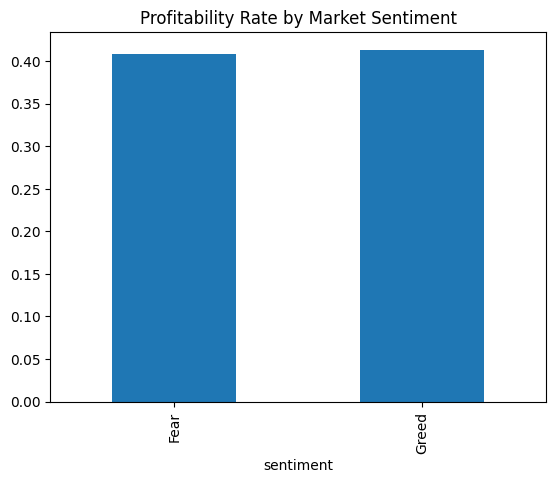

In [33]:
profit_rate = merged_df.groupby('sentiment')['is_profitable'].mean()
profit_rate.plot(kind='bar')
plt.title('Profitability Rate by Market Sentiment')
plt.savefig('outputs/profitability_by_sentiment.png', bbox_inches='tight')
plt.show()



In [34]:

os.makedirs('csv_files', exist_ok=True)
merged_df.to_csv('csv_files/processed_trader_sentiment_data.csv', index=False)


In [35]:
# Risk exposure proxy using trade size (USD)
risk_exposure = (
    merged_df
    .groupby('sentiment')['Size USD']
    .agg(['mean', 'median'])
)

risk_exposure


,mean,median
sentiment,,
Fear,7182.011019,749.40
Greed,4635.764077,551.32


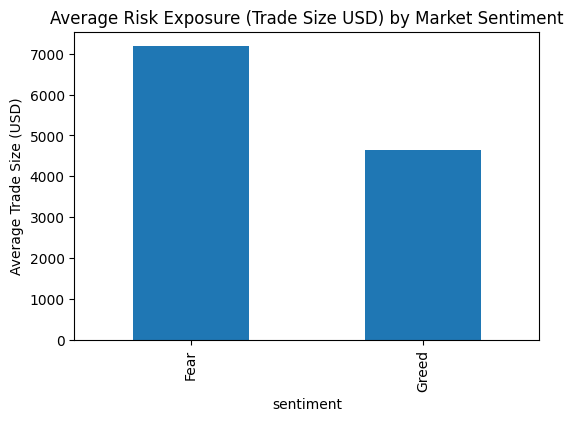

In [36]:
risk_exposure['mean'].plot(
    kind='bar',
    figsize=(6,4),
    title='Average Risk Exposure (Trade Size USD) by Market Sentiment'
)
plt.ylabel('Average Trade Size (USD)')
plt.show()


In [37]:
risk_exposure['mean'].plot(kind='bar', figsize=(6,4))
plt.title('Average Risk Exposure (Trade Size USD) by Market Sentiment')
plt.ylabel('Average Trade Size (USD)')
plt.savefig('outputs/risk_exposure_by_sentiment.png')
plt.close()


In [38]:
# Trader segmentation by activity level
trader_activity = (
    merged_df
    .groupby('Account')
    .size()
    .reset_index(name='trade_count')
)

# Label frequent vs infrequent traders
threshold = trader_activity['trade_count'].median()
trader_activity['segment'] = trader_activity['trade_count'].apply(
    lambda x: 'Frequent' if x >= threshold else 'Infrequent'
)

# Merge back
merged_df = merged_df.merge(trader_activity[['Account', 'segment']], on='Account')


Compare PnL by segment

In [39]:
segment_perf = merged_df.groupby('segment')['Closed PnL'].mean()
segment_perf


,Closed PnL
segment,
Frequent,42.493421
Infrequent,95.216371


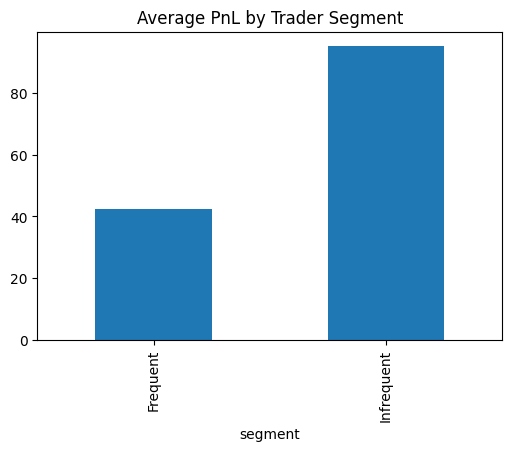

In [40]:
segment_perf.plot(kind='bar', figsize=(6,4), title='Average PnL by Trader Segment')
plt.show()

### Note on Leverage

The provided trader dataset does not contain an explicit leverage column. Therefore, absolute trade size (USD) is used as a proxy for effective risk exposure, which is consistent with margin trading behavior where larger position sizes imply higher risk exposure (trade size proxy).

# **Segmentation** **Analysis**

Traders were segmented based on their trading frequency using the median number of trades per account.


Reduce risk exposure (position size) for frequent and high-risk traders, especially during Fear sentiment regimes.



In [41]:
from sklearn.linear_model import LogisticRegression

features = merged_df[['abs_size_usd']]
X = features.fillna(0)
y = merged_df['is_profitable']

model = LogisticRegression()
model.fit(X, y)

model.score(X, y)



0.5887613745040668

In [42]:
risk_by_trader = (
    merged_df
    .groupby('Account')['abs_size_usd']
    .mean()
    .reset_index(name='avg_trade_size')
)


In [43]:
threshold = risk_by_trader['avg_trade_size'].median()

risk_by_trader['risk_segment'] = risk_by_trader['avg_trade_size'].apply(
    lambda x: 'High Risk' if x >= threshold else 'Low Risk'
)

risk_by_trader.head()


,Account,avg_trade_size,risk_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734,High Risk
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327,Low Risk
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898,High Risk
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933,Low Risk
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782,Low Risk


In [44]:
merged_df = merged_df.merge(
    risk_by_trader[['Account', 'risk_segment']],
    on='Account',
    how='left'
)


In [45]:
risk_perf = (
    merged_df
    .groupby(['risk_segment', 'sentiment'])['Closed PnL']
    .mean()
    .reset_index()
)

risk_perf


,risk_segment,sentiment,Closed PnL
0,High Risk,Fear,83.234638
1,High Risk,Greed,113.713010
2,Low Risk,Fear,28.985071
3,Low Risk,Greed,22.514832


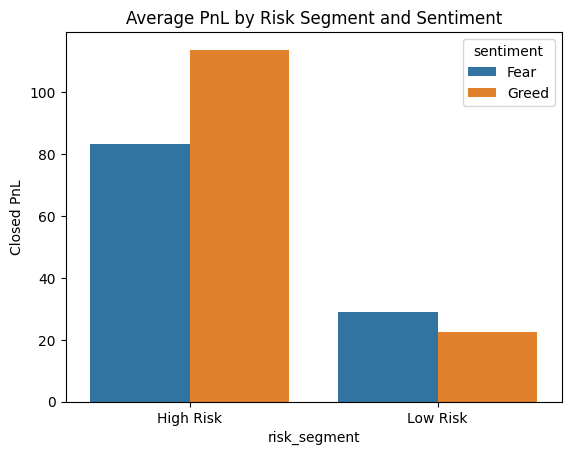

In [46]:
import seaborn as sns

sns.barplot(
    data=risk_perf,
    x='risk_segment',
    y='Closed PnL',
    hue='sentiment'
)
plt.title('Average PnL by Risk Segment and Sentiment')
plt.show()


**Consistent vs Inconsistent traders**

In [47]:
consistency = (
    merged_df
    .groupby('Account')['Closed PnL']
    .std()
    .reset_index(name='pnl_volatility')
)

threshold = consistency['pnl_volatility'].median()

consistency['consistency_segment'] = consistency['pnl_volatility'].apply(
    lambda x: 'Consistent' if x <= threshold else 'Inconsistent'
)

merged_df = merged_df.merge(
    consistency[['Account', 'consistency_segment']],
    on='Account',
    how='left'
)


In [48]:
merged_df.groupby(['consistency_segment', 'sentiment'])['Closed PnL'].mean()


consistency_segment  sentiment
Consistent           Fear           6.734244
                     Greed         21.311685
Inconsistent         Fear          90.920235
                     Greed        109.394318
Name: Closed PnL, dtype: float64

# **Actionable Strategy Recommendations**

### Strategy 1: Reduce Risk Exposure During Fear Regimes

**Observation:**  
Fear-driven market conditions are associated with significantly higher PnL volatility and worse downside outcomes (lower p10 PnL), while average trade sizes remain elevated.

**Actionable Rule:**  
During Fear sentiment regimes:
- Reduce average position size (risk exposure), especially for high-risk traders.
- Avoid increasing trade frequency to compensate for losses.
- Prioritize capital preservation over aggressive positioning.

**Rationale:**  
Large positions under Fear amplify drawdowns due to unstable market conditions. Lowering exposure improves risk-adjusted performance.


### Strategy 2: Selective Aggression During Greed Regimes

**Observation:**  
Greed-driven markets show higher trading activity and participation, with frequent traders achieving better average PnL compared to infrequent traders.

**Actionable Rule:**  
During Greed sentiment regimes:
- Allow increased trade frequency for historically frequent and active traders.
- Maintain controlled position sizing rather than maximizing risk exposure (trade size proxy).
- Avoid encouraging infrequent traders to overtrade.

**Rationale:**  
Greed environments reward experience and execution efficiency. Selective aggression improves returns without materially increasing downside risk.


### Strategy 3: Favor Consistent Traders Across All Regimes

**Observation:**  
Traders with lower PnL volatility (consistent traders) demonstrate more stable performance across both Fear and Greed regimes.

**Actionable Rule:**  
- Allocate higher capital limits to consistent traders.
- Impose stricter risk caps on highly volatile traders, especially during Fear regimes.

**Rationale:**  
Consistency is a stronger indicator of long-term profitability than short-term gains.


## Key Insights
- Average risk exposure (proxied by trade size) is higher during Fear periods, suggesting traders take larger positions despite adverse sentiment, potentially reflecting panic-driven or forced trades.
- PnL distribution during Fear periods shows higher volatility, suggesting unstable market conditions.
- Trade frequency increases during Greed, pointing to possible overconfidence-driven trading behavior.
- Risk exposure, proxied by average trade size, is higher during Greed periods, indicating increased risk-taking behavior.
- Frequent traders exhibit different performance characteristics compared to infrequent traders, indicating that trading intensity is an important behavioral dimension alongside market sentiment.

## Conclusion
Market sentiment has a noticeable influence on trader behavior. Greed-driven markets encourage higher risk exposure and trading frequency, increasing risk exposure, while Fear periods are associated with volatile profitability. These patterns highlight the importance of sentiment-aware risk management strategies in trading systems.

